In [31]:
%load_ext autoreload
%autoreload 2

import os
import csv
import numpy as np
import shapely
import pytorch_lightning as pl

from torch.utils.data import DataLoader, RandomSampler, ConcatDataset
from pytorch_lightning.utilities import CombinedLoader
from pathlib import Path
from datetime import datetime

import dl_toolbox.callbacks as callbacks
import dl_toolbox.modules as modules 
import dl_toolbox.networks as networks
import dl_toolbox.datasets as datasets
import dl_toolbox.torch_collate as collate
import dl_toolbox.utils as utils

import rasterio.windows as windows

if os.uname().nodename == 'WDTIS890Z': 
    data_root = Path('/mnt/d/pfournie/Documents/data')
    home = Path('/home/pfournie')
    save_root = data_root / 'outputs'
elif os.uname().nodename == 'qdtis056z': 
    data_root = Path('/data')
    home = Path('/d/pfournie')
    save_root = data_root / 'outputs'
else:
    #data_root = Path('/work/OT/ai4geo/DATA/DATASETS')
    data_root = Path(os.environ['TMPDIR'])
    home = Path('/home/eh/fournip')
    save_root = Path('/work/OT/ai4usr/fournip') / 'outputs'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# datasets params
dataset_name = 'DIGITANIE'
data_path = data_root / dataset_name
nomenclature = datasets.DigitanieNomenclatures['building'].value
num_classes=len(nomenclature)
crop_size=256
crop_step=256
bands = [1,2,3]

# split params
split = home / f'dl_toolbox/dl_toolbox/datamodules/digitanie_Toulouse.csv'

train_idx = [1,2,3,4,5]
train_aug = 'd4_color-3'

val_idx = [6,7]
val_aug = 'd4'

unsup_idx = [0]
unsup_aug = 'd4'

# dataloaders params
batch_size = 8
epoch_steps = 10
num_samples = epoch_steps * batch_size
num_workers=6

# network params
in_channels=len(bands)
out_channels=num_classes
pretrained = False
encoder='efficientnet-b0'

# module params
mixup=0. # incompatible with ignore_zero=True
class_weights = [1.] * num_classes
initial_lr=0.001
ttas=[]
alpha_ramp=utils.SigmoidRamp(2,4,0.,0.)
pseudo_threshold=0.9
consist_aug='color-5'
ema_ramp=utils.SigmoidRamp(2,4,0.9,0.99)

# trainer params
num_epochs = 5
#max_steps=num_epochs * epoch_steps
accelerator='gpu'
devices=1
multiple_trainloader_mode='min_size'
limit_train_batches=1
limit_val_batches=1
save_dir = save_root / dataset_name
log_name = 'toulouse'
ckpt_path=None # '/data/outputs/test_bce_resisc/version_2/checkpoints/epoch=49-step=14049.ckpt'

In [3]:
log_name = f'train={train_idx}_val={val_idx}'

train_data_src = [
    src for src in datasets.datasets_from_csv(
        data_path,
        split,
        train_idx
    )
]

train_sets = [
    datasets.Raster(
        data_src=src,
        crop_size=crop_size,
        aug=train_aug,
        bands=bands,
        nomenclature=nomenclature
    ) for src in train_data_src
]

train_set = ConcatDataset(train_sets)

val_data_src = [
    src for src in datasets.datasets_from_csv(
        data_path,
        split,
        val_idx
    )
]

val_sets = [
    datasets.PretiledRaster(
        data_src=src,
        crop_size=crop_size,
        crop_step=crop_size//2,
        aug=val_aug,
        bands=bands,
        nomenclature=nomenclature
    ) for src in val_data_src
]

val_set = ConcatDataset(val_sets)

train_set_coords = []

for src in train_data_src:
    if isinstance(src.zone, windows.Window):
        bbox = windows.bounds(src.zone, src.meta['transform'])
        train_set_coords.append(datasets.polygon_from_bbox(bbox))
    elif isinstance(src.zone, shapely.Polygon):
        train_set_coords.append(src.zone.exterior.coords)

unsup_sets = []

unsup_data_src = datasets.datasets_from_csv(
    data_path,
    split,
    unsup_idx
)

for src in unsup_data_src:
    
    if isinstance(src.zone, windows.Window):
        bbox = windows.bounds(src.zone, src.meta['transform'])
        poly_zone = shapely.Polygon(
            shell=datasets.polygon_from_bbox(bbox),
            #holes=train_set_coords
        )
        
    elif isinstance(src.zone, shapely.Polygon):
        poly_zone = shapely.Polygon(
            shell=src.zone.exterior.coords,
            #holes=train_set_coords
        )
        
    src.zone = poly_zone
    
    unsup_set = datasets.Raster(
        data_src=src,
        crop_size=crop_size,
        aug=unsup_aug,
        bands=bands,
        nomenclature=nomenclature,
    )
    
    unsup_sets.append(unsup_set)
    
unsup_set = ConcatDataset(unsup_sets) 

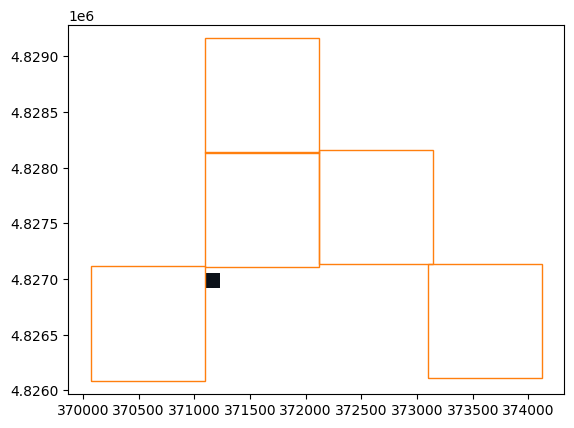

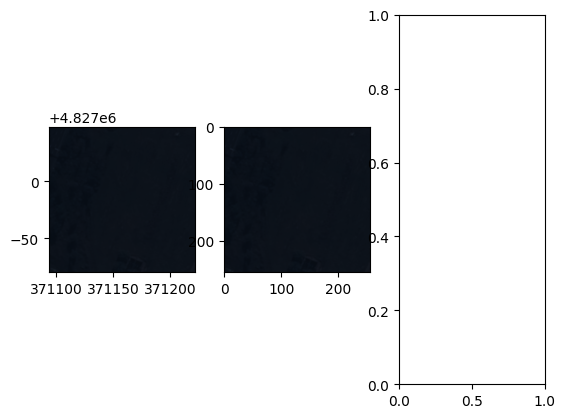

In [4]:
%matplotlib inline
from shapely import plotting
from matplotlib import colors
import matplotlib.pyplot as plt
from copy import copy
from rasterio import plot as rioplt

def shape_color(name, alpha):
    color = colors.to_rgba(name)
    facecolor = list(color)
    facecolor[-1] = alpha
    facecolor = tuple(facecolor)
    edgecolor = color
    return facecolor, edgecolor

fig, ax = plt.subplots(1, 1)
f0, e0 = shape_color("C0", 0)
f1, e1 = shape_color("C1", 0)

ds = val_set.datasets[0]
poly_zone = ds.data_src.zone
poly_zone = shapely.Polygon(datasets.polygon_from_bbox(windows.bounds(ds.data_src.zone, ds.data_src.meta['transform'])))
patch_zone = plotting.patch_from_polygon(poly_zone, facecolor=f0, edgecolor=e0)
#ax.add_patch(copy(patch_zone))

for coord in train_set_coords:
    train_poly = shapely.Polygon(coord)
    patch = plotting.patch_from_polygon(train_poly, facecolor=f1, edgecolor=e1)
    ax.add_patch(copy(patch))
    
item =ds[1]
rioplt.show(item['image'].numpy(), ax=ax, transform=item['crop_tf'])
ax.axis('equal')
ax.autoscale_view()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
rioplt.show(item['image'].numpy(), ax=ax1, transform=item['crop_tf'])
ax2.imshow(item['image'].numpy().transpose(1,2,0)[...,:3])
#ax3.imshow(item['label'].numpy())

In [32]:
train_dataloaders = {}
train_dataloaders['sup'] = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate.CustomCollate(),
    sampler=RandomSampler(
        data_source=train_set,
        replacement=True,
        num_samples=num_samples
    ),
    num_workers=num_workers,
    drop_last=True
)

#train_dataloaders['unsup'] = DataLoader(
#    dataset=unsup_set,
#    batch_size=batch_size,
#    collate_fn=collate.CustomCollate(),
#    sampler=RandomSampler(
#        data_source=unsup_set,
#        replacement=True,
#        num_samples=num_samples
#    ),
#    num_workers=num_workers,
#    drop_last=True
#)

val_dataloader = DataLoader(
    dataset=val_set,
    sampler=RandomSampler(
        data_source=val_set,
        replacement=True,
        num_samples=num_samples//10
    ),
    collate_fn=collate.CustomCollate(),
    batch_size=batch_size,
    num_workers=num_workers
)

In [33]:
network = networks.SmpUnet(
    encoder=encoder,
    in_channels=in_channels,
    out_channels=out_channels,
    pretrained=pretrained
)

### Building lightning module
module = modules.Supervised(
    mixup=mixup, # incompatible with ignore_zero=True
    network=network,
    num_classes=num_classes,
    class_weights=class_weights,
    initial_lr=initial_lr,
    ttas=ttas,
    #alpha_ramp=alpha_ramp,
    #pseudo_threshold=pseudo_threshold,
    #consist_aug=consist_aug,
    #ema_ramp=ema_ramp
)

In [36]:
### Metrics and plots from confmat callback
metrics_from_confmat = callbacks.MetricsFromConfmat(        
    num_classes=num_classes,
    class_names=[label.name for label in nomenclature]
)

logger = pl.loggers.TensorBoardLogger(
    save_dir=save_dir,
    name=log_name,
    version=f'{datetime.now():%d%b%y-%Hh%Mm%S}'
)

### Trainer instance
trainer = pl.Trainer(
    max_epochs=num_epochs,
    accelerator=accelerator,
    devices=devices,
    num_sanity_val_steps=0,
    limit_train_batches=limit_train_batches,
    limit_val_batches=limit_val_batches,
    logger=logger,
    callbacks=[
        pl.callbacks.ModelCheckpoint(),
        pl.callbacks.EarlyStopping(
            monitor='Val_loss',
            patience=10
        ),
        metrics_from_confmat,
        callbacks.MyProgressBar()
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


In [37]:
trainer.fit(
    model=module,
    train_dataloaders=CombinedLoader(train_dataloaders, mode=multiple_trainloader_mode),
    val_dataloaders=val_dataloader,
    ckpt_path=ckpt_path
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | network | SmpUnet          | 6.3 M 
1 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.007    Total estimated model params size (MB)


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s, v_num=0m05]
Validation: 0it [00:00, ?it/s]

TypeError: on_validation_batch_end() missing 1 required positional argument: 'dataloader_idx'

In [ ]:
pred_idx = [8]
pred_aug = 'no'

pred_dir = os.path.join(
    save_dir,
    log_name,
    logger.log_dir,
    dataset_name
)

pred_data_src = [
    src for src in datasets.datasets_from_csv(
        data_path,
        split,
        pred_idx
    )
]

pred_sets = [
    datasets.PretiledRaster(
        data_src=src,
        crop_size=crop_size,
        crop_step=crop_size//2,
        aug=pred_aug,
        bands=bands,
        nomenclature=nomenclature
    ) for src in pred_data_src
]

for pred_set in pred_sets:
    
    pred_dataloader = DataLoader(
        dataset=pred_set,
        shuffle=False,
        collate_fn=collate.CustomCollate(),
        batch_size=batch_size,
        num_workers=num_workers
    )

    pred_writer = callbacks.MergedTiffPredsWriter(
        out_path=pred_dir,
        write_mode='probas',
        data_src=pred_set.data_src,
        crop_size=pred_set.crop_size,
        merge_mode='linear'
    )

    pred_trainer = lightning.Trainer(
        accelerator=accelerator,
        devices=devices,
        logger=None,
        callbacks=[
            pred_writer,
            #callbacks.MyProgressBar(),
        ]
    )
    
    pred_trainer.predict(
        model=module,
        dataloaders=pred_dataloader,
        return_predictions=False
    )